In [17]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji

stop_words = set(stopwords.words("english"))


In [18]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [19]:
print(np.where(data["product_category"] != "Automotive"))

(array([], dtype=int64),)


In [20]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()

  # Replace emojis with text representation
  text = emoji.demojize(text).replace(':', ' ')

  # Remove stopwords
  tokens = [i for i in word_tokenize(text) if i not in stop_words]

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [21]:
cleanly_tokenize("Product was a cheap made material that cost 73.00.  I thought it was what I had on my bike. I searched again and found what I was looking for.  And this was cheaper and not only that it is a stronger  material.  😠😡😲 was not pleased at all!!!")

['product',
 'cheap',
 'made',
 'material',
 'cost',
 'thought',
 'bike',
 'searched',
 'found',
 'looking',
 'cheaper',
 'stronger',
 'material',
 'angry_face',
 'enraged_face',
 'astonished_face',
 'pleased']

In [22]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(['Love it!!!!! Super Cute....😉',
       'So nice. The hid light so bright cool. 😎👍',
       'This item did not stay working for very long😒😒',
       'Excellent product 😃👍',
       "These Jack's worked as expected despite some of the other views that I saw they did not look different from the ones I took off. I had to drill two holes one for each side in order to install The new Jack's but they work great definitely a five-star product I have prime but they got here in today's Mike STARK have a great day😊",
       "I was so unorganized in my car before I got this.  Everything that I would put on the seat eventually ended up on the floor.  Not anymore!  I don't use the &#34;hidden&#34; part as such because I like to keep a box or Kleenex in there.  I also keep my insulated water bottle, pen, pad, sunglasses, makeup mirror, fold up rainboots, window breaker for emergencies, and a canister of window wipes to clean off my dog's nose prints all inside of this one organizer!  It doesn't

In [23]:
def get_review_body(review_id):
  return cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0])

get_review_body("R1CKCTN2BXKOBQ")

['work', 'great', 'grinning_face', 'grinning_face']

In [24]:
n = 10000
trunc = data.sample(n)
#trunc = data;
trunc['review_body'].head(10)

228015    I bought this for my son's car; compressor wen...
145617                                              Love it
395319    The fit was good no problem installing it. I h...
415017                                      They work sofar
87360     This is a great filter. Before this purchase, ...
65659     Extremely disappointed, purchased new front an...
283660    Worked as advertised and bolted right in. Star...
21407                      Bright bright bright !!!!!!!!!!!
340409    Fixed my dashboard for a fraction of the cost ...
228664    not worth the price its better to make your ow...
Name: review_body, dtype: object

In [25]:
vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=3000
)

counts = vectorizer.fit_transform(trunc["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
print(words)

# print words that contain _ (emojis)
print([word for word in words if "_" in word])

df_tf_idf = pd.DataFrame(counts, columns=words)


c:\Users\stijn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\stijn\AppData\Local\Temp\ipykernel_18192\3211577921.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


['aaa' 'ab' 'ability' ... 'zip' 'zipper' 'zx']
['thumbs_up']


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# Create an SVM classifier
#classifier = MultinomialNB(force_alpha=True)
#classifier = KNeighborsClassifier()
classifier = SVC()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.689


In [27]:
print(trunc.iloc[[0]]["star_rating"].values[0])

5


In [28]:
#Naive Bayes

#Start with five stars

#Number of documents that have the given star 
df_y = np.zeros(5);
for i in range(5):
    df_y[i] = np.size(np.where(trunc["star_rating"] == i + 1))
print(df_y)
predicted_stars = np.zeros(n);
df_tf_idf_werkbaar = df_tf_idf.to_numpy()
df_tf_idf_werkbaar_t = df_tf_idf_werkbaar.T;
total_correct = 0;

for k in range(n):
    ratings = np.zeros(5);
    for stars_no in range(5):
        star_i = np.array(np.where(trunc["star_rating"] == stars_no + 1));
        rating = 1;
        j = 0
        for word in df_tf_idf_werkbaar[k]:
            #We zitten nu in een afzonderlijke behoordeling te kijken of het woord erin zit
            sum = 0;
            for i in star_i[0]:
                sum = sum + df_tf_idf_werkbaar_t[j][i]
            p_given_word = (sum + 1) / (df_y[stars_no] + 2)
            #print(p_given_word)
            if word == 1:
                rating = rating * p_given_word
            else: 
                rating = rating * (1 - p_given_word)
            j = j + 1
        #print(rating)
        ratings[stars_no] = rating;
    print(ratings)
    predicted_stars[k] = (np.argmax(ratings) + 1)
    if predicted_stars[k] ==  trunc.iloc[[k]]["star_rating"].values[0]:
        total_correct = total_correct + 1;
    print(predicted_stars[k], trunc.iloc[[k]]["star_rating"].values[0])
accuracy = total_correct / n;
print("The accuracy is: ", accuracy)



[ 828.  383.  683. 1293. 6813.]


KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt;
# from joblib import Parallel
# plt.hist(y_train, bins=5)
# plt.show()
# # 8000 rijen per 3000 kolommen
# x_train = X_train.to_numpy();
# most_similiar = np.zeros(8000);
# cores = 12;
# def calcMostSim(z):
#     sim_score = np.zeros(8000);
#     for i in np.arange(8000):
#         if(i == z):
#             break;
#         for j in np.arange(3000):
#             if(x_train[i][j] == x_train[0][j]):
#                 sim_score[i] += 1;
#     most_similiar[z] = np.argmax(x_train)
# Parallel(n_jobs=cores)(calcMostSim(z) for z in range(0, 8000))
# print(most_similiar)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming X is your TF-IDF matrix and Y is the corresponding star ratings

# Split the data into training and test sets
X_train, X_test, y_train, y_
test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# undersampler = RandomUnderSampler(sampling_strategy="all")
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and fit the logistic regression model with class weights
model = LogisticRegression(max_iter=10000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

NameError: name 'y_' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions, squared=False)

1.203951826278776

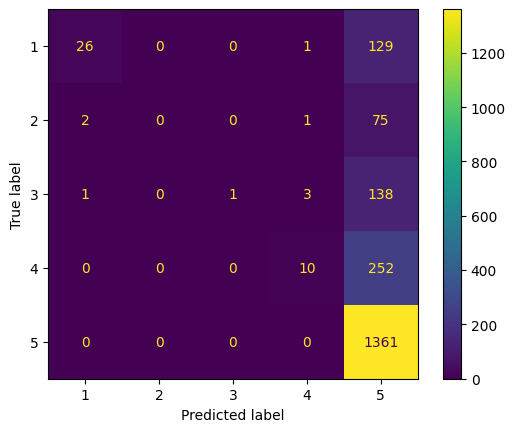

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test
)

plt.show()

In [ ]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * len(X_test))


# Retrieve the corresponding sample and its information
sample_text = trunc.iloc[X_test.index[random_idx]]['review_body']
sample_tokenized = cleanly_tokenize(sample_text)
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: Awesome!
Tokenized Text: ['awesome']
Real Stars: 5
Predicted Stars: 5


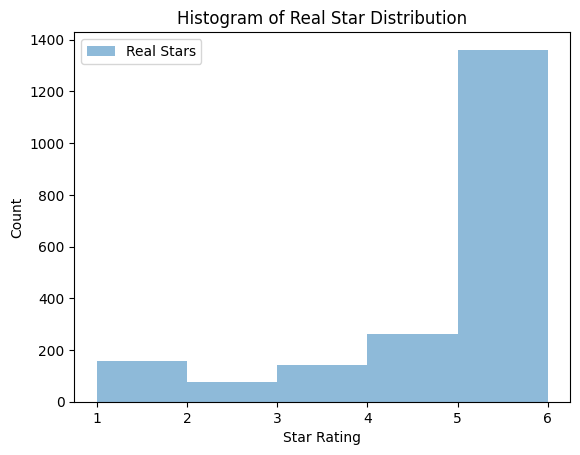

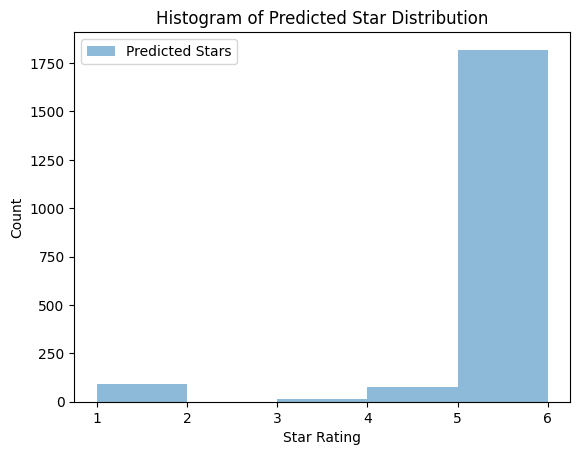

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [ ]:
print(len(y_test.loc[y_test == 1]))
print(len(y_test.loc[y_test == 2]))
print(len(y_test.loc[y_test == 3]))
print(len(y_test.loc[y_test == 4]))
print(len(y_test.loc[y_test == 5]))

156
78
143
262
1361


In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud


trunced = trunc[trunc['star_rating'] == 5]

trunced_cleaned = cleanly_tokenize(trunced['review_body'])
textt = " ".join(review for review in trunced['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object, got 'Series'

In [ ]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\stijn\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [ ]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [ ]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))
